In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns 
from scipy import stats
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import h2o
from h2o.automl import H2OAutoML
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.neural_network import MLPRegressor
from scipy.stats import norm
import copy
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool, metrics, cv
import xgboost as xgb
from scipy.stats import gmean
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder


In [2]:
train_df =  pd.read_csv('sub_train.csv')
test_df  =  pd.read_csv('sub_test.csv')
for c in train_df.columns:
    if train_df[c].dtypes != 'float64':
        print(c)

startdate
climateregions__climateregion


In [3]:
exclude_cols = ['index', 'startdate']
target=["contest-tmp2m-14d__tmp2m"]
main_attrs = [c for c in train_df.columns if c not in exclude_cols and c not in target]
print("Main features:", len(main_attrs))

Main features: 59


In [18]:
main_attrs

['contest-wind-h500-14d__wind-hgt-500',
 'contest-slp-14d__slp',
 'nmme-tmp2m-34w__ccsm3',
 'elevation__elevation',
 'lon',
 'contest-prwtr-eatm-14d__prwtr',
 'lat',
 'climateregions__climateregion',
 'contest-pres-sfc-gauss-14d__pres',
 'season_sin',
 'day_of_year_sin',
 'contest-precip-14d__precip',
 'contest-wind-uwnd-250-14d__wind-uwnd-250',
 'nmme-prate-34w__cfsv2',
 'nmme-prate-34w__nasa',
 'nmme-prate-56w__gfdlflora',
 'wind-uwnd-250-2010-7',
 'contest-wind-vwnd-925-14d__wind-vwnd-925',
 'nmme-prate-34w__nmmemean',
 'nmme0-prate-34w__ccsm30',
 'contest-wind-h850-14d__wind-hgt-850',
 'contest-wind-uwnd-925-14d__wind-uwnd-925',
 'nmme0-prate-56w__cfsv20',
 'nmme-prate-34w__cancm3',
 'contest-rhum-sig995-14d__rhum',
 'nmme-prate-34w__gfdlflorb',
 'wind-hgt-850-2010-4',
 'contest-wind-vwnd-250-14d__wind-vwnd-250',
 'wind-hgt-100-2010-2',
 'wind-uwnd-250-2010-18',
 'wind-hgt-10-2010-5',
 'wind-uwnd-250-2010-15',
 'wind-uwnd-250-2010-4',
 'nmme0-prate-56w__nasa0',
 'nmme0-prate-34w__c

<AxesSubplot:>

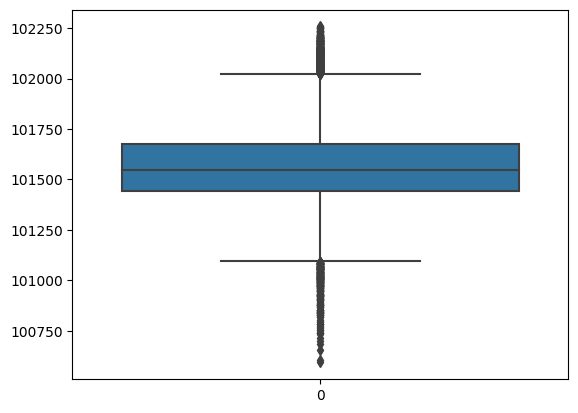

In [21]:
import seaborn as sns
sns.boxplot(test_df['contest-slp-14d__slp'])


<AxesSubplot:>

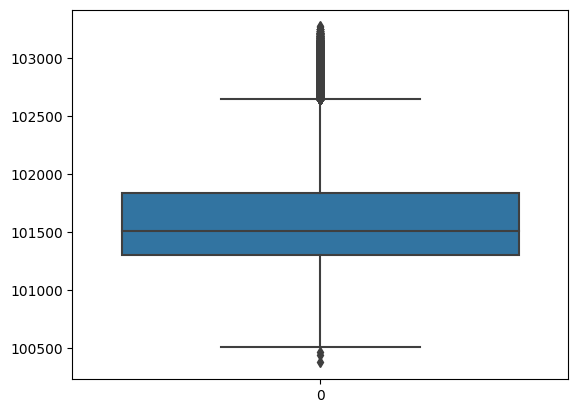

In [22]:
import seaborn as sns
sns.boxplot(train_df['contest-slp-14d__slp'])


In [23]:
idx_list = np.where((train_df['contest-slp-14d__slp']<=102500) & (train_df['contest-slp-14d__slp']>=100500))

In [25]:
train_df = train_df.iloc[idx_list]
train_df.shape

(361313, 61)

In [28]:
def train_model_by_X_y(_X, _y, iterations=5000):
    skf = KFold(n_splits=5, random_state=2048, shuffle=True)
    skf.get_n_splits(_X, _y)

    train_index_list = []
    test_index_list = []
    train_x_list = []
    val_x_list = []
    train_y_list = []
    val_y_list = []

    for i, (train_index, test_index) in enumerate(skf.split(_X, _y)):
        train_index_list.append(train_index)
        test_index_list.append(test_index)

        train_x_list.append(_X[train_index, :])
        val_x_list.append(_X[test_index, :])
        train_y_list.append(_y[train_index])
        val_y_list.append(_y[test_index])    
   

    cat_models = []
    for i in range(5):
        train_x, val_x = train_x_list[i], val_x_list[i]
        train_y, val_y = train_y_list[i], val_y_list[i],
        clf = CatBoostRegressor(iterations=iterations, task_type="GPU",
                           devices='0:1')
        clf.fit(train_x, train_y, eval_set=[(val_x, val_y)], verbose=5000, early_stopping_rounds=100)
        cat_models.append(clf)
    
    return cat_models


In [29]:
def cal_train_pred(models, _X):
    preds = []
    for model in models:
        preds.append(model.predict(_X))
    s = 0
    for pred in preds:
        s += pred
    s = s/5
    return s

In [30]:
X = train_df[main_attrs].values
y = np.array(train_df[target[0]].tolist())
cat_models = train_model_by_X_y(X, y)

Learning rate set to 0.072392
0:	learn: 8.8329164	test: 8.8288323	best: 8.8288323 (0)	total: 6.62ms	remaining: 33.1s
4999:	learn: 0.3180657	test: 0.3467328	best: 0.3467328 (4999)	total: 24s	remaining: 0us
bestTest = 0.3467328039
bestIteration = 4999
Learning rate set to 0.072392
0:	learn: 8.8302675	test: 8.8397867	best: 8.8397867 (0)	total: 6.2ms	remaining: 31s
4999:	learn: 0.3187549	test: 0.3465120	best: 0.3465120 (4999)	total: 23.6s	remaining: 0us
bestTest = 0.3465119777
bestIteration = 4999
Learning rate set to 0.072392
0:	learn: 8.8437465	test: 8.7849326	best: 8.7849326 (0)	total: 8ms	remaining: 40s
4999:	learn: 0.3176852	test: 0.3474060	best: 0.3474060 (4999)	total: 23.4s	remaining: 0us
bestTest = 0.3474060133
bestIteration = 4999
Learning rate set to 0.072392
0:	learn: 8.8256059	test: 8.8611826	best: 8.8611826 (0)	total: 6.14ms	remaining: 30.7s
4999:	learn: 0.3184782	test: 0.3466267	best: 0.3466267 (4999)	total: 23.1s	remaining: 0us
bestTest = 0.3466266782
bestIteration = 4999
Le

In [31]:
preds = []
for cat_model in tqdm(cat_models):
    preds.append(cat_model.predict(test_df[main_attrs].values))
s = 0
for pred in preds:
    s += pred
s = s/5
df = pd.read_csv('./sample_solution.csv')
df['contest-tmp2m-14d__tmp2m'] = s
df.to_csv('submission_outlier_v1.csv', index=False)

best_df = pd.read_csv('best_sub.csv')
y_best = best_df[target[0]].values

from numpy import dot
from numpy.linalg import norm

cos_sim = dot(y_best, s)/(norm(y_best)*norm(s))
print("cos_sim with best submission:", cos_sim)

100%|████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.94it/s]


cos_sim with best submission: 0.9999135337313454
